In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Code tonen/verbergen."></form>''')

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

In [3]:
# GLOBALS

FIGSIZE = (10,7)
TAB20 = plt.cm.tab20.colors  # kleurschema kiezen

In [4]:
# data inladen

# alles uit tabel reservering met res_dat in 2022

# inputfiles 


data_folder = '.\\data_res_22\\'  
data_files = glob(data_folder + 'res_2022*')  

# naar dataframe omzetten

df = pd.concat([pd.read_csv(f, sep='\t', parse_dates=[16,17,18],
                            dtype={'behrvest':str, 'leenvest':str, 'zoekvest':str, 'levrvest':str, 'archief':str}) 
                for f in data_files])

# check op dubbels
if df['res_id'].duplicated().sum() > 0:
    print('Dubbele res_id\'s gevonden')

In [5]:
# reserveringsinstellingen ophalen

res_params_file = data_folder + 'res_instellingen.csv'
res_params = pd.read_csv(res_params_file, sep='\t', dtype={'vestnr':str})

# check op dubbels
if res_params['vestnr'].duplicated().sum() > 0:
    print('Dubbele vestnrs gevonden')

# reserveerkost herbereken naar 1 waarde ipv plaatsen vs ophalen
res_params['kost_reservering'] = res_params['inbrengenreserveringbalie'] + res_params['ophalenreserveringbalie']
res_params['kost_ibl'] = res_params['inbrengenaanvraagbalie'] + res_params['ophalenaanvraagbalie']
res_params['kost_niet_ophalen'] = res_params['inbrengenreserveringbalie'] + res_params['nietophalen']

# overbodig kolommen verwijderen
res_params = res_params.drop(['inbrengenreserveringbalie', 'ophalenreserveringbalie',
                              'inbrengenaanvraagbalie', 'ophalenaanvraagbalie', 
                              'nietophalen', 'reglementtabel', 'omschrijving'], axis=1)

# dataframe mergen met parameters
df = df.merge(res_params, left_on='behrvest', right_on='vestnr', how='left')
df = df.drop('vestnr', axis=1)  # kolom vestnr laten vallen want is dubbel met behrvest

# check op dubbels
if df['res_id'].duplicated().sum() > 0:
    print('Dubbele res_id\'s gevonden')

df = df.sort_values('res_dat')

In [6]:
# data opkuisen

# Dtypes aanpassen om geheugen te mnideren

naar_int8 = []
naar_category = ['behrvest', 'leenvest', 'zoekvest', 'levrvest', 'status', 'soort', 'soorti', 'bron', 'archief', 'materiaal',
                 'vestiging', 'instantie_id', 'bibliotheek']

new_types = {'int8': naar_int8, 'category': naar_category}

for new_type, cols in new_types.items():
    for col in cols:
        df[col] = df[col].astype(new_type)
        
# reserveringen zonder archiefreden verwijderen
df = df[df['archief'].notnull()]


In [7]:
# tsv met aantal exemplaren per vestiging inlezen
bezit = pd.read_csv('./data_res_22/bezit_2022.csv', sep = '\t')

bezit_vest = bezit[['eigenaar', 'tot_exemplaren']]
bezit_vest.columns = ['behrvest', 'bezit_vest']
bezit_instantie = bezit.groupby('instantie_id').sum().reset_index()
bezit_instantie.columns = ['instantie_id', 'bezit_instantie']

df = df.merge(bezit_vest, on='behrvest', how='left')
df['bezit_vest'] = df['bezit_vest'].fillna(0).astype(int)
df = df.merge(bezit_instantie, on='instantie_id', how='left')
df['bezit_instantie'] = df['bezit_vest'].fillna(0).astype(int)


In [8]:
leners = pd.read_csv('./data_res_22/act_leners_2022.csv', sep = '\t')
leners.columns = ['instantie_id', 'act_leners_22', 'uit_verl_22']

df = df.merge(leners, on='instantie_id', how='left')
df['act_leners_22'] = df['act_leners_22'].fillna(0).astype(int)
df['uit_verl_22'] = df['uit_verl_22'].fillna(0).astype(int)

In [9]:
# dataframe opslaan in csv
df.to_csv('./data/reserveringen_2022.csv', sep=';', index=True)

In [10]:
# tellen hoeveel kalenderdagen tussen reserveringsdatum en uitleendatum

df['dagen_wacht'] = df['uit_dat'].dt.date - df['res_dat'].dt.date  # verschil in kalenderdagen
df['dagen_wacht'] = df['dagen_wacht'].dt.days  # omzetten naar getal

# Reserveringen 2022

Er is een dump gemaakt van alle reserveringen met een reserveerdatum tussen 01/01/2022 en 31/12/2022 die werden geplaatst in Wise of zijn meegekomen bij conversie (enkel actieve reserveringen worden geconverteerd, geen historiek). Die dump is verspreid over verschillende csv's en worden hier terug tot één dataframe samengevoegd.

Daarnaast is voor elke bibliotheek ook 3 parameters uit de reserveringsinstellingen opgehaald: de kost voor een gewone reservering, de kost voor een ibl-reservering en de kost voor het niet-ophalen van een reservering. Dit is gebaseerd op het reglement voor een reservering van een boek volwassenen fictie voor een abonnement Volwassene. Het onderscheid tussen kost bij plaatsing en kost bij ophalen is samengevoegd tot 1 parameter. Wanneer er een kost bij plaatsen wordt aangerekend is dat bedrag ook bij de kost voor niet-ophalen geteld.

Voor bibliotheken waarbij meerdere reserveermethodes zijn gemaakt werd de methode die geldig was op 31/12/2022 genomen.

Uitleg bij de kolommen:

|kolomnaam | uitleg|
|----------|-------|
|res_id | id-nummer van de reservering|
|actor_id | actor_id|
|titelnr | titelnr|
|exem_id | exem_id (enkel ingevuld bij exemplaarreservering)|
|behrvest | vestiging waar reservering werd geplaatst|
|leenvest | vestiging waar reservering werd uitgeleend|
|zoekvest | vestiging of netwerk waarin exemplaren in aanmerking komen|
|levrvest | vestiging waaruit exemplaar werd geleverd|
|res_exem_id | exem_id van het exemplaar dat uiteindelijk werd gereserveerd|
|status | status van de reservering|
|soort | soort van reservering op moment van honoreren: <br> B=vestigingsreservering, N=netwerkreservering, I=IBL, E=externe reservering|
|soorti | soort die de reservering had op moment van plaatsen|
|bron | bron: B(alie), I(nternet), (bul)K|
|archief | archiefreden: hoe werd de reservering afgehandeld|
|res_groep | wanneer de reservering als een groepsreservering wordt geplaatst is hier het id van de groep ingevuld|
|res_dat | datum van reservering|
|eind_dat | vervaldatum van de reservering|
|uit_dat | eerste uitleendatum van het exemplaar na de reserveerdatum|
|vestiging | naam van de vestiging waar reservering werd geplaatst (=behrvest)|
|instantie_id | instantie_id van de bibliotheek|
|bibliotheek | naam van de instantie|
|kost_reservering | prijs van een reservering in eurocent|
|kost_ibl | prijs van een ibl in eurocent|
|kost_niet_ophalen | prijs voor niet ophalen van een reservering in eurocent|
|bezit_vest | aantal exemplaren in bezit in de vestiging waar reservering werd geplaatst|
|bezit_instantie | aantal exemplaren in bezit in de instantie waar reservering werd geplaatst|
|act_leners_22 | aantal actieve leners in 2022 in de instantie waar reservering werd geplaatst|
|uit_verl_22 | uitleningen + verlengingen in 2022 in de instantie waar reservering werd geplaatst|
|dagen_wacht | aantal kalenderdagen tussen datum plaatsen reservering en uitlenen reservering|



*link naar dataset: [reserveringen_2022.csv](./data/reserveringen_2022.csv)*

De kolom *uit_dat* bevat de eerste uitleendatum van het exemplaar na de reserveerdatum. Bij - geslaagde - reserveringen zou dat dus moeten overeenkomen met het moment waarop het gereservereerde exemplaar is uitgeleend. Op basis van deze twee datums kunnen we dus de wachttijd gaan berekenen in kalenderdagen. Dat verschil in kalenderdagen zit in de kolom *dagen_wacht*.


Eerste 5 rijen van dataset:

In [11]:
pd.set_option('display.max_columns', None)
display(df.head(5))

res_id  actor_id  titelnr  exem_id behrvest leenvest zoekvest levrvest  \
0  1234467   2992555  1588779        0     6430     6430     6430     6430   
1  1235772   3012109  3271316        0     6520     6520     6520     6520   
2  1235773   3017088  1347333        0     6520     6520     6520     6520   
3  1093751   1926630  1119341        0     6060     6060     N606     6060   
4  1093752   1926630  1142535        0     6060     6060     N606     6060   

   res_exem_id status soort soorti bron archief  res_groep materiaal  \
0     23799453      Z     B      B    B       1          0        B2   
1     23967372      Z     B      B    B       1          0        B2   
2     24170688      Z     B      B    B       1          0        B2   
3     15274863      Z     N      N    I       1    1093751        D2   
4     16251644      Z     N      N    I       1    1093752        D2   

              res_dat            eind_dat    uit_dat             vestiging  \
0 2022-01-01 00:00:00 2022-04-07 11:50:46 2022-01-26              Overijse   
1 2022-01-01 00:00:00 2022-05-07 11:04:39 2022-04-07  Bibliotheek Tervuren   
2 2022-01-01 00:00:00 2022-04-15 12:02:32 2022-03-16  Bibliotheek Tervuren   
3 2022-01-01 00:10:24 2022-02-06 11:12:11 2022-01-04                Bertem   
4 2022-01-01 00:11:14 2022-02-06 11:12:14 2022-01-04                Bertem   

  instantie_id           bibliotheek  kost_reservering  kost_ibl  \
0         I643  Bibliotheek Overijse               0.0     100.0   
1         I652  Bibliotheek Tervuren               0.0     100.0   
2         I652  Bibliotheek Tervuren               0.0     100.0   
3         I606    Bibliotheek Bertem               0.0     100.0   
4         I606    Bibliotheek Bertem               0.0     100.0   

   kost_niet_ophalen  bezit_vest  bezit_instantie  act_leners_22  uit_verl_22  \
0              100.0       50331            50331           2933        93775   
1              100.0       49139            49139           3677       122645   
2              100.0       49139            49139           3677       122645   
3              100.0       46279            46279           1759        74550   
4              100.0       46279            46279           1759        74550   

   dagen_wacht  
0         25.0  
1         96.0  
2         74.0  
3          3.0  
4          3.0

In [12]:
# helpfuncties

def plot_stacked_bar(data, xlabels, legendlabels, ylabel='aantal reserveringen', xlabel='categorie', title='',
                     legendtitle=''):
    """ helpfunctie om een stacked barplot te maken"""
    fig, ax = plt.subplots(figsize=FIGSIZE)
    startpos = [0] * len(xlabels)  # om bottom voor stacked bar te berekenen
    
    for i in range(len(legendlabels)):
        plt.bar(x=xlabels, height=data[i], bottom=startpos, label=legendlabels[i], color=TAB20[i])
        startpos += data[i]  # bottom opnieuw instellen met nieuwe y-waaarden
        plt.legend(loc='upper right', ncol=2, bbox_to_anchor=(1.2, 1.), title=legendtitle)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

def highlight(val):
    return f'background-color: lightsteelblue'

# Reserveringen per soort

De meeste reserveringen zijn gewone Vestigigingsreserveringen (B) of Netwerkreserveringen (N). Slechts een klein deel van de Vestigingsreserveringen zijn omgezet naar een Netwerkreservering.

Externe reserveringen (E) komen overeen met de vroegere werking van IBL (voor april 2022) en werden sindsdien vervangen door de nieuwe IBL-reserveringen (I). 

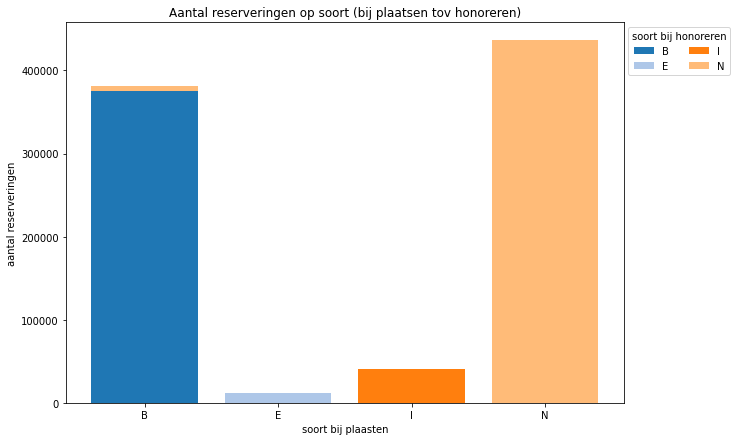

In [13]:
aantal_per_soort_en_soorti = df.pivot_table(columns='soorti', index='soort', aggfunc='count', fill_value=0)['behrvest']
data = aantal_per_soort_en_soorti.values

soorteni = aantal_per_soort_en_soorti.columns
soorten = aantal_per_soort_en_soorti.columns

plot_stacked_bar(data, xlabels=soorteni, legendlabels=soorten, xlabel='soort bij plaasten',
                 legendtitle='soort bij honoreren',
                 title='Aantal reserveringen op soort (bij plaatsen tov honoreren)')

# Gewone reserveringen

IBL en Externe reserveringen (= reservering op een tijdelijk exemplaar) laten we buiten beschouwing, onder gewone reserveringen verstaan we Netwerkreserveringen en Vestigingsreserveringen.

In [14]:
gewoon = df[df['soort'].isin(['B', 'N'])].reset_index(drop=True)
totaal_reserveringen = gewoon.shape[0]
print('Totaal aantal reserveringen in 2022: {}'.format(totaal_reserveringen))

Totaal aantal reserveringen in 2022: 817675


### Reserveringen geteld op status

De gegevens zijn op 22 januari 2023 uit Wise gehaald, dus voor de laatste maanden van 2022 zijn er meer reserveringen die nog de status Actief (en archiefreden 0) of Uitgeleend hebben.

De verschillende statussen zijn:

    A: Actief (reservering staat nog open),
    B: Bericht (reservering gehonoreerd en lener geattendeerd),
    O: Ontvangen (reservering gehonoreerd en lener nog niet geattendeerd),
    R: Retour (?),
    T: Transport (reservering gehonoreerd, exemplaar onderweg naar ophaallocatie),
    U: Uitgeleend (reservering gehonoreerd en uitgeleend aan lener),
    Z: Afgehandeld (exemplaar terug ingeleverd of geannuleerd)

In [15]:
aantal_per_status = gewoon['status'].value_counts().reset_index()
aantal_per_status.columns = ['status', 'aantal']
display(aantal_per_status)

status  aantal
0      Z  761977
1      U   36967
2      A   11636
3      B    4603
4      R    1586
5      T     853
6      O      53

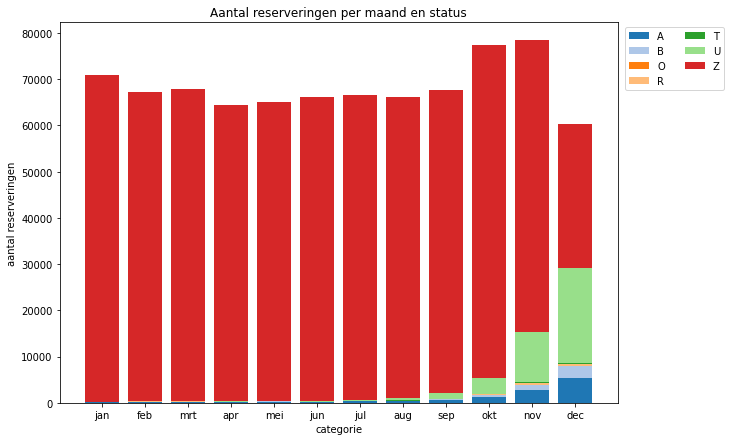

In [16]:
maanden = ['jan', 'feb', 'mrt', 'apr', 'mei', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'dec']

aantal_per_maand_en_status = gewoon[['res_dat', 'status']].pivot_table(columns=gewoon.res_dat.dt.month, index='status', 
                                                                       aggfunc='count', fill_value=0)
data = aantal_per_maand_en_status.values
statussen = sorted(gewoon['status'].unique())

plot_stacked_bar(data, maanden, statussen, title='Aantal reserveringen per maand en status')

Aantal reserveringen per maand tellen en uitsplitsen op archiefreden.

De archiefredenen zijn:

    0: Niet gearchiveerd, 
    1: Exemplaar geleverd, 
    2: Titel geleverd, 
    3: Titel uit andere vest., 
    4: Te lang open (aantal dagen ingevuld bij 'Melding openstaande reserveringen' in dagen (zie Reglementsmateriaal)., 
    5: Lidmaatschap vervallen, 
    6: Titel/exemplaar verwijderd, 
    7: Vervaldatum overschreden, 
    8: Niet opgehaald, 
    9: Handmatig verwijderd,
    E: Annulering leverend systeem, 
    I: Geannuleerd door klant, via 'Mijn Menu'., 
    K: Geannuleerd door IBL-V; al geleverd door een andere organisatie, 
    N: Geannuleerd door IBL-V; niet leverbaar via IBL-V, 
    P: Plank annulering door lener,
    S: Stop-datum overschreden,
    W: Levering geweigerd


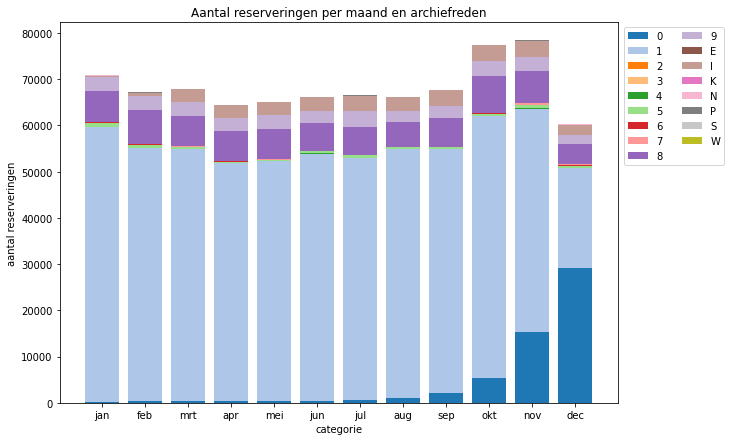

In [17]:
# voor elke archiefreden de aantallen per maand berekenen

# labels en kleuren instellen
archiefredenen = sorted(gewoon['archief'].astype(str).unique())
tab20 = plt.cm.tab20.colors

# data berekenen
gewoon['archief'] = gewoon['archief'].astype(str)  # om geen dubbels owv andere dtype in index te krijgen
aantal_per_maand_en_reden = gewoon[['res_dat', 'archief']].pivot_table(columns=gewoon.res_dat.dt.month, index='archief', 
                                                                       aggfunc='count', fill_value=0)
data = aantal_per_maand_en_reden.values  # enkel ndarray gebruiken

# data plotten
plot_stacked_bar(data, maanden, archiefredenen, title='Aantal reserveringen per maand en archiefreden')



### Aantal reserveringen per bron

Hoeveel reserveringen werden aan de balie (B) geplaatst, hoeveel via Mijn Bibliotheek (I). Bron K zijn reseveringen in bulk.

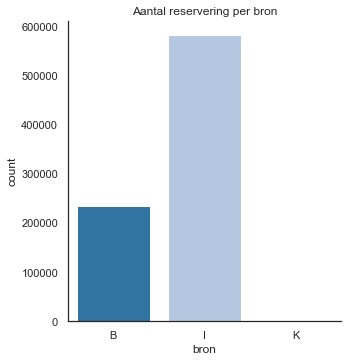

In [18]:
sns.set(rc={'figure.figsize':FIGSIZE})
sns.set_style('white')
sns.catplot(data=gewoon, x='bron', kind='count', palette=TAB20)
plt.title('Aantal reservering per bron')
plt.show()

### Aantal reserveringen per RMT

Reserveringen worden vooral voor boeken gebruikt (ca. 80% van alle reserveringen). Vooral volwassenen fictie (40%), volwassenen non-fictie (20%), jeugd fictie (20%).

Bij niet-boeken zijn dvd's het populairst met 5% van alle reserveringen.


De top 10 van meest gereserveerde rmt's

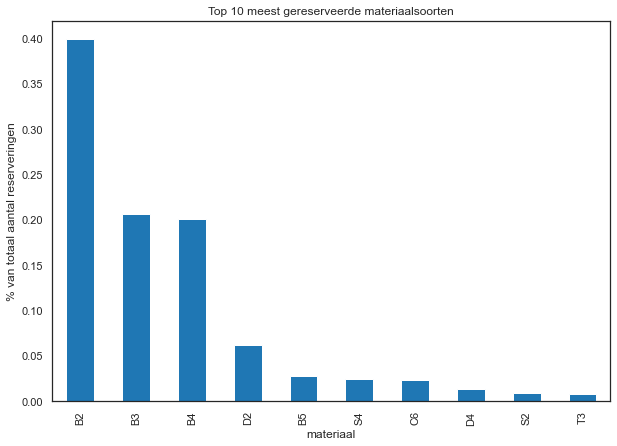

In [19]:
top10_materiaal = gewoon.value_counts('materiaal', normalize=True).head(10)

top10_materiaal.plot(kind='bar', figsize=FIGSIZE, color=TAB20[0])
plt.title('Top 10 meest gereserveerde materiaalsoorten')
plt.ylabel('% van totaal aantal reserveringen')
plt.show()

### Aantal reserveringen per bibliotheek (instantie)


In [20]:
# aantallen per instantie berekenen

# lijst van instantiecodes met verwoording laden
inst_verw = df[['instantie_id', 'bibliotheek']].drop_duplicates()

# berekenen hoeveel reserveringen er per instantie waren
reserveringen_per_bib = gewoon.groupby('instantie_id').size().sort_values(ascending=False).reset_index()
reserveringen_per_bib.columns = ['instantie_id', 'reserveringen']

# verwoording van instantiecode aan telling toevoegen
reserveringen_per_bib = reserveringen_per_bib.merge(inst_verw, on='instantie_id', how='left')

# bezit per instantie toevoegen
reserveringen_per_bib = reserveringen_per_bib.merge(bezit_instantie, on='instantie_id', how='left')

# aantal actieve leners toevoegen
reserveringen_per_bib = reserveringen_per_bib.merge(leners, on='instantie_id', how='left')

# parameters voor reserveringen toevoegen
params = res_params[['instantie_id', 'kost_reservering', 'kost_niet_ophalen']].drop_duplicates()

# dubbele rij voor Roeselare verwijderen (gratis reservering voor magazijn?)
roes_gratis = (params['instantie_id'] == 'I453') & (params['kost_reservering'] == 0)
params = params.drop(params[roes_gratis].index, axis=0)
reserveringen_per_bib = reserveringen_per_bib.merge(params, on='instantie_id', how='left')


Gemiddeld waren er 2700 reservering per bibliotheek in 2022 (geteld voor 302 bibliotheken). Dat gemiddelde wordt wel ernstig omhoog getrokken door bibliotheken met heel grote aantallen (bijna 120.000 en 80.000). 
De mediaan is met 1137 minder dan de helft van het gemiddelde en een beter cijfer om de verdeling in te schatten. 50% van de bibliotheken hadden tussen de 451 en 2327 reserveringen.

count         mean          std  min     25%     50%      75%  \
reserveringen  302.0  2707.529801  8625.187633  1.0  451.25  1136.5  2327.25   

                    max  
reserveringen  118581.0

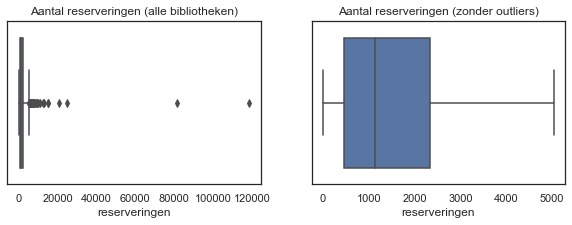

In [21]:
# gegevens plotten

# reeksverdeling van aantal reserveringen per bibliotheek weergeven
display(reserveringen_per_bib[['reserveringen']].describe().T)


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.boxplot(data=reserveringen_per_bib, x='reserveringen', showfliers=True, ax=axs[0])
sns.boxplot(data=reserveringen_per_bib, x='reserveringen', showfliers=False, ax=axs[1])
axs[0].set_title('Aantal reserveringen (alle bibliotheken)')
axs[1].set_title('Aantal reserveringen (zonder outliers)')
plt.show()


De Top 10 van bibliotheken met meeste reserveringen en de Top 10 van minste reserveringen:

Antwerpen en Leuven zijn de twee bibliotheken met afgetekend veel meer reserveringen. In Voeren was er 1 reservering in het hele jaar.

In [22]:
# top 10 berekenen
top_10_bibliotheken = reserveringen_per_bib.head(10).set_index('bibliotheek')
bottom_10_bibliotheken = reserveringen_per_bib.tail(10).sort_values('reserveringen').set_index('bibliotheek')

top_10_bibliotheken_vet = top_10_bibliotheken.style.applymap(highlight, subset='reserveringen')
bottom_10_bibliotheken_vet = bottom_10_bibliotheken.style.applymap(highlight, subset='reserveringen')

print()
print('Bibliotheken met meeste reserveringen: ')
display(top_10_bibliotheken_vet)

print()
print('Bibliotheken met minst reserveringen: ')
display(bottom_10_bibliotheken_vet)


Bibliotheken met meeste reserveringen: 



Bibliotheken met minst reserveringen: 


Grotere bibliotheken zullen meer reserveringen hebben dan kleinere bibliotheken. Het aantal reserveringen is sterk gecorrelerreerd met de grootte van de collectie en meer nog met het aantal actieve leners en aantal transacties.

Correlatiecoëfficiënten tussen reserveringen en bezit, leners of transacties:

In [23]:
display(reserveringen_per_bib[['reserveringen', 'bezit_instantie', 'act_leners_22', 'uit_verl_22']].corr())


reserveringen  bezit_instantie  act_leners_22  uit_verl_22
reserveringen         1.000000         0.740276       0.851322     0.851655
bezit_instantie       0.740276         1.000000       0.943967     0.935475
act_leners_22         0.851322         0.943967       1.000000     0.978961
uit_verl_22           0.851655         0.935475       0.978961     1.000000

Om bibliotheken onderling te vergelijken kunnen we het aantal reserveringen per actieve lener berekenen.

count      mean       std       min       25%       50%  \
res_per_lener  302.0  0.562587  0.577232  0.001783  0.212777  0.357729   

                   75%       max  
res_per_lener  0.74814  4.825153

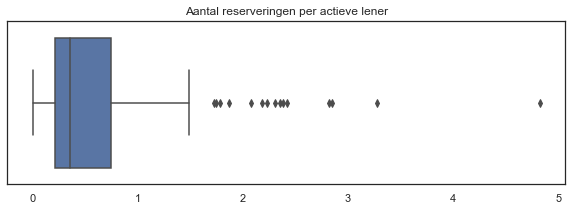


Bibliotheken met meeste reserveringen per actieve lener: 



Bibliotheken met misnt reserveringen per actieve lener: 


In [24]:
reserveringen_per_bib['res_per_lener'] = reserveringen_per_bib['reserveringen'] / reserveringen_per_bib['act_leners_22']

display(reserveringen_per_bib[['res_per_lener']].describe().T)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,3))
sns.boxplot(data=reserveringen_per_bib, x='res_per_lener', showfliers=True)
plt.title('Aantal reserveringen per actieve lener')
plt.xlabel('')
plt.show()


top_10_bibliotheken = reserveringen_per_bib.sort_values('res_per_lener', ascending=False).set_index('bibliotheek').head(10)
top_10_bibliotheken_vet = top_10_bibliotheken.style.applymap(highlight, subset='res_per_lener')

bottom_10_bibliotheken = reserveringen_per_bib.sort_values('res_per_lener', ascending=True).set_index('bibliotheek').head(10)
bottom_10_bibliotheken_vet = bottom_10_bibliotheken.style.applymap(highlight, subset='res_per_lener')

print()
print('Bibliotheken met meeste reserveringen per actieve lener: ')
display(top_10_bibliotheken_vet)

print()
print('Bibliotheken met minst reserveringen per actieve lener: ')
display(bottom_10_bibliotheken_vet)

Bij de bibliotheken met meest aantal reserveringen per actieve lener zien we maar 1 bibliotheek met betalende reservering (Zonnedorp laten we buiten beschouwing). Omgekeerd is er maar 1 bibliohteek zonder kost voor een reservering bij de bibliotheken met het kleinste aantal reserveringen per actieve lener, een bibliotheek die pas eind 2022 is overgestapt op Wise en dus geen data over het volledige jaar heeft.

De kostprijs van een reservering lijkt dus een belangrijke factor voor het al dan niet plaatsen van een reservering. Dit wordt bevestigd als we kijken naar de verhouding tussen de kostprijs en het aantal geplaatste reserveringen.

Bibliotheken met gratis reserveringen (donkerblauwe punten in grafiek) hebben in vergelijking een groter aantal reserveringen vergeleken met bibliotheken van eenzelfde grootte (obv aantal actieve leners):

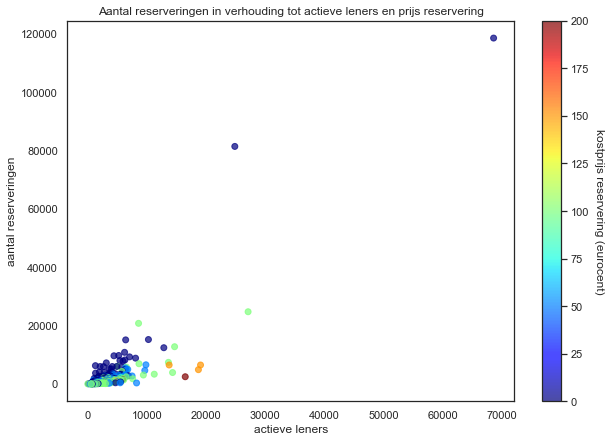

In [25]:
fig, ax = plt.subplots(figsize=FIGSIZE)
x, y, z = (reserveringen_per_bib['act_leners_22'], 
           reserveringen_per_bib['reserveringen'], 
           reserveringen_per_bib['kost_reservering'])
plt.scatter(x=x, y=y, c=z, alpha=0.7, cmap='jet')
plt.xlabel('actieve leners')
plt.ylabel('aantal reserveringen')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('kostprijs reservering (eurocent)', rotation=270)
plt.title('Aantal reserveringen in verhouding tot actieve leners en prijs reservering')
plt.show()

Het verwacht aantal reserveringen per lener bij een bibliotheek zonder kostprijs ligt gemiddeld meer dan 2 keer zo hoog als bij een bibliotheek met kostprijs. Het verschil tussen geen kost of wel een kost is aanzienlijk groter dan tussen de verschillende tarieven onderling:

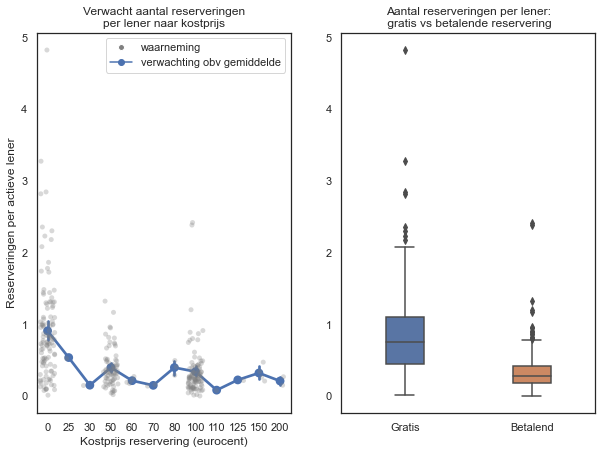

count      mean       std       min       25%       50%       75%  \
Gratis    113.0  0.910187  0.730200  0.012674  0.443225  0.757739  1.104061   
Betalend  189.0  0.354763  0.315877  0.001783  0.177353  0.276163  0.424767   

               max  
Gratis    4.825153  
Betalend  2.419779

In [26]:
# tijdelijk dataframe maken om alle betalende reserveringen te groeperen
betalend = reserveringen_per_bib['kost_reservering'] > 0
temp = reserveringen_per_bib[['kost_reservering', 'res_per_lener']].copy()
temp['betalend'] = betalend

# data plotten
fig, axs = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=FIGSIZE)

# plot 1 = res_per_lener op kost_reservering
sns.pointplot(data=reserveringen_per_bib, x='kost_reservering', y='res_per_lener', 
              estimator=np.mean, errorbar=None, ax=axs[0])
sns.stripplot(data=reserveringen_per_bib, x='kost_reservering', y='res_per_lener', alpha=0.3, color='grey', ax=axs[0], jitter=0.35)
axs[0].set_title('Verwacht aantal reserveringen\nper lener naar kostprijs')
axs[0].set_ylabel('Reserveringen per actieve lener')
axs[0].set_xlabel('Kostprijs reservering (eurocent)')
legend_strip = matplotlib.lines.Line2D([], [], color="white", marker='o', markerfacecolor="gray", label='waarneming')
legend_point = matplotlib.lines.Line2D([], [], marker='o', label='verwachting obv gemiddelde')
axs[0].legend(handles=(legend_strip, legend_point))

# plot 2 = gratis vs betalend gegroepeerd
sns.boxplot(data=temp, x='betalend', y='res_per_lener', width=0.3, showfliers=True,
            boxprops=dict(alpha=1), ax=axs[1])

axs[1].set_xticklabels(labels=['Gratis', 'Betalend'])
axs[1].set_title('Aantal reserveringen per lener:\n gratis vs betalende reservering')
axs[1].set_xlabel('')
axs[1].set_ylabel('')



plt.show()

display(reserveringen_per_bib.groupby(betalend).describe()['res_per_lener'].set_axis(['Gratis', 'Betalend']))

Het aantal reserveringen per actieve lener voor gratis reserveringen vergeleken met betalende reserveringen (ongeacht welke kost):

## Wachttijd bij geleverde reserveringen

De wachttijd is berekend op basis van het verschil tussen de reserveerdatum en de datum van de eerstvolgende uitleenactie van het exemplaar. Het verschil is gemeten in kalenderdagen.

Enkel reserveringen die een archiefreden 1 hebben (="Exemplaar geleverd") worden in de berekening opgenomen. Niet-afgehaalde of geannuleerde reserveringen zouden een vertekend beeld geven. Reserveringen met archiefreden 1 maar waar geen uitleendatum aan kon worden gekoppeld zijn genegeerd.


De gemiddelde wachttijd tussen het plaatsen van een reservering en het uitlenen van het exemplaar is 11,58 kalenderdagen. De mediaan ligt een pak lager op 7 kalenderdagen. 25% van de reserveringen wordt binnen de 3 dagen na reservering geleend, 75% wordt binnen de 15 dagen geleend. Reserveringen die langer dan 33 dagen open staan kunnen als outliers worden gezien.

count      mean        std  min  25%  50%   75%    max
dagen_wacht  598476.0  11.57922  15.783266  0.0  3.0  7.0  15.0  372.0

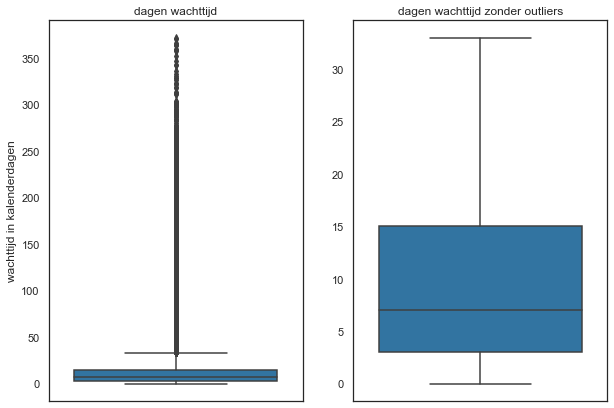

In [27]:
# set maken met alleen gehonoreerde reserveringen
gewoon_succes = gewoon[(gewoon['archief'] == '1') & (gewoon['uit_dat'].notnull())]

display(gewoon_succes[['dagen_wacht']].describe().T)

fig, ax = plt.subplots(ncols=2, figsize=FIGSIZE)
sns.boxplot(data=gewoon_succes, y='dagen_wacht', color=TAB20[0], showfliers=True, ax=ax[0])
sns.boxplot(data=gewoon_succes,  y='dagen_wacht', color=TAB20[0], showfliers=False, ax=ax[1])
ax[0].set_title('dagen wachttijd')
ax[0].set_ylabel('wachttijd in kalenderdagen')
ax[1].set_title('dagen wachttijd zonder outliers')
ax[1].set_ylabel('')
plt.show()

De data is begin januari uit Wise gehaald. Omdat we enkel kijken naar afgehaalde reserveringen om de wachttijd te berekenen zullen voor de maanden november en december enkel de snel opgehaalde reserveringen zijn geteld. Voor deze maanden zien we daarom een iets kortere wachttijd.

De verdeling bij de andere maanden is wel heel gelijkaardig, enkel in de zomermaanden juli en augustus zijn er meer reserveringen die langer op de plank hebben gestaan.

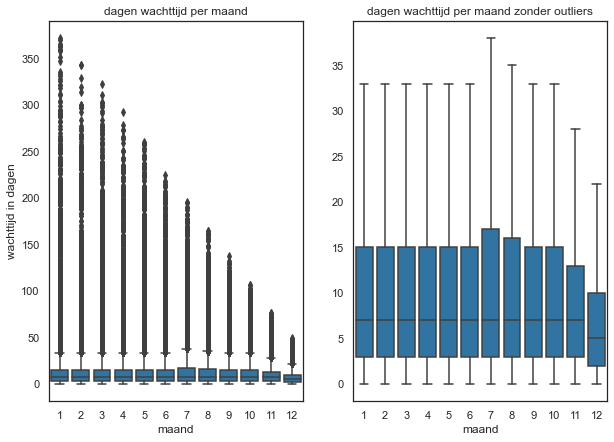

In [28]:
%%capture --no-display
maand = gewoon_succes['res_dat']
gewoon_succes['maand'] = maand.dt.month

fig, ax = plt.subplots(ncols=2, figsize=FIGSIZE)
sns.boxplot(data=gewoon_succes, x='maand', y='dagen_wacht', color=TAB20[0], showfliers=True, ax=ax[0])
sns.boxplot(data=gewoon_succes, x='maand', y='dagen_wacht', color=TAB20[0], showfliers=False, ax=ax[1])
ax[0].set_title('dagen wachttijd per maand')
ax[0].set_ylabel('wachttijd in dagen')
ax[1].set_title('dagen wachttijd per maand zonder outliers')
ax[1].set_ylabel('')
plt.show()

Uit de data kan niet afgeleid worden of de reservering werd gehonoreerd op een aanwezig exemplaar of op een uitgeleend exemplaar, wat nochtans een grote invloed zal hebben op de wachttijd. Wel kunnen we zien dat reserveringen die in een groep van meerdere titelnummers zijn opgenomen sneller werden uitgeleend:

75% van de groepsreserveringen werd binnen de 14 dagen geleend, bij niet gegroepeerde reserveringen is dat binnen de 17 dagen.

dagen_wacht                                             \
                           count       mean        std  min  25%  50%   75%   
is_groepsreservering                                                          
False                   151493.0  14.126864  21.699307  0.0  3.0  7.0  17.0   
True                    446983.0  10.715763  13.077129  0.0  3.0  7.0  14.0   

                                         
                       90%   95%    max  
is_groepsreservering                     
False                 31.0  46.0  372.0  
True                  25.0  33.0  331.0

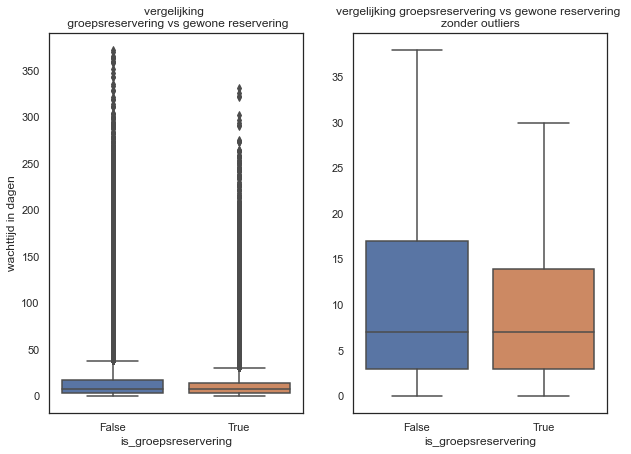

In [29]:
%%capture --no-display

gewoon_succes.loc[:, 'is_groepsreservering'] = gewoon_succes.res_groep > 0

display(gewoon_succes.groupby('is_groepsreservering')[['dagen_wacht']].describe(percentiles=[0.25, 0.5, 0.75, .9, .95]))


fig, ax = plt.subplots(ncols=2, figsize=FIGSIZE)
sns.boxplot(data=gewoon_succes, x='is_groepsreservering', y='dagen_wacht', showfliers=True, ax=ax[0])
sns.boxplot(data=gewoon_succes, x='is_groepsreservering', y='dagen_wacht', showfliers=False, ax=ax[1])
ax[0].set_title('vergelijking \n groepsreservering vs gewone reservering')
ax[0].set_ylabel('wachttijd in dagen')
ax[1].set_title('vergelijking groepsreservering vs gewone reservering \nzonder outliers')
ax[1].set_ylabel('')
plt.show()


### Wachttijd per materiaal
De verschillen in wachttijd tussen de verschillende materialen (enkel 10 meest gereserveerde rmt's):

Vooral bij tijdschriften ligt de wachttijd hoger dan bij de andere materialen. Misschien speelt hier de invloed van reserveren op aanwezige werken (wat bij tijdschriften minder vaak zal voorkomen)?

count       mean        std  min  25%  50%   75%    max
materiaal                                                            
B2         253506.0  11.911276  13.884584  0.0  3.0  8.0  16.0  359.0
B3         121664.0  11.775587  15.058132  0.0  3.0  7.0  16.0  333.0
B4         107989.0  11.592560  19.774549  0.0  2.0  6.0  13.0  372.0
D2          40956.0   9.463229  12.778524  0.0  3.0  6.0  12.0  347.0
B5          14927.0  11.760032  21.785173  0.0  2.0  6.0  12.0  364.0
C6          13940.0   9.497704  14.024112  0.0  2.0  6.0  11.0  322.0
S4          13816.0  13.991387  19.906357  0.0  3.0  8.0  17.0  289.0
D4           8254.0   9.693967  12.390839  0.0  2.0  6.0  13.0  264.0
S2           5659.0  11.091182  16.993121  0.0  2.0  6.0  13.0  294.0
T3           3794.0  15.674222  17.040524  0.0  4.0  9.0  23.0  204.0

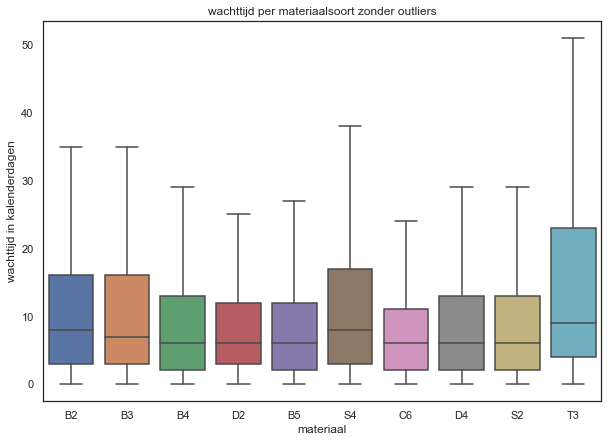

In [30]:
topmaterialen = gewoon['materiaal'].value_counts(ascending=False).head(10).index


temp = gewoon_succes.loc[gewoon_succes['materiaal'].isin(topmaterialen), ['materiaal', 'dagen_wacht']].reset_index()

display(temp.groupby('materiaal').describe()['dagen_wacht'].dropna().sort_values('count', ascending=False))
data = []
for rmt in topmaterialen:
    wachttijd_materiaal = temp[temp['materiaal'] == rmt]['dagen_wacht'].dropna().values
    data.append(wachttijd_materiaal)

fig, ax= plt.subplots(figsize=FIGSIZE)
sns.boxplot(data=data, orient='v', showfliers=0)
plt.xticks(range(len(topmaterialen)), labels=topmaterialen)
plt.ylabel('wachttijd in kalenderdagen')
plt.xlabel('materiaal')
plt.title('wachttijd per materiaalsoort zonder outliers')
plt.show()

### Niet-succesvolle reserveringen = reserveringen met status Z (afgesloten) maar geen archiefreden 1

In [31]:
niet_succes = df.copy().loc[(df.status == 'Z') & (df.archief != '1'), :]
totaal_niet_succes = niet_succes.shape[0]
print('{} niet-succesvolle reserveringen'.format(totaal_niet_succes))
print('= {:.2f} % van het totaal aantal gewone reserveringen'.format(totaal_niet_succes / totaal_reserveringen * 100))
print()

164801 niet-succesvolle reserveringen
= 20.15 % van het totaal aantal gewone reserveringen



### Redenen voor niet-succesvolle reserveringen

Ongeveer de helft zijn reserveringen die wel werden klaar gezet maar niet zijn opgehaald. Een klein kwart werd door de bibliotheek verwijderd en ongeveerd een vijfde werd door de klant geannuleerd voordat de reservering werd gehonoreerd.

De 5 meest voorkomende redenen voor niet-afhalen:

    8: Niet opgehaald, 
    9: Handmatig verwijderd,
    I: Geannuleerd door klant, via 'Mijn Menu'.,
    5: Lidmaatschap vervallen, 
    7: Vervaldatum overschreden

In [32]:
niet_succes_op_archief = niet_succes.value_counts('archief')
niet_succes_op_archief_norm = niet_succes.value_counts('archief', normalize=True) * 100
overzicht_niet_succes_archief = pd.concat([niet_succes_op_archief, niet_succes_op_archief_norm], axis=1)
overzicht_niet_succes_archief.columns = ['aantal', 'pct']
display(overzicht_niet_succes_archief.head(5))

        

aantal        pct
archief                   
8         79757  48.395944
9         39386  23.899127
I         32542  19.746239
5          6477   3.930195
7          4712   2.859206

Heeft de prijs voor het niet-ophalen van een reservering invloed op het al dan niet ophalen van een reservering? 

Bij ongeveer de helft van alle geplaatste reservering is er een kost voor het niet-ophalen van de reservering. Bij de niet-opgehaalde reserveringen (archiefreden = 8) is het aandeel van reserveringen zonder kosten voor niet-ophalen gestegen tot 56%

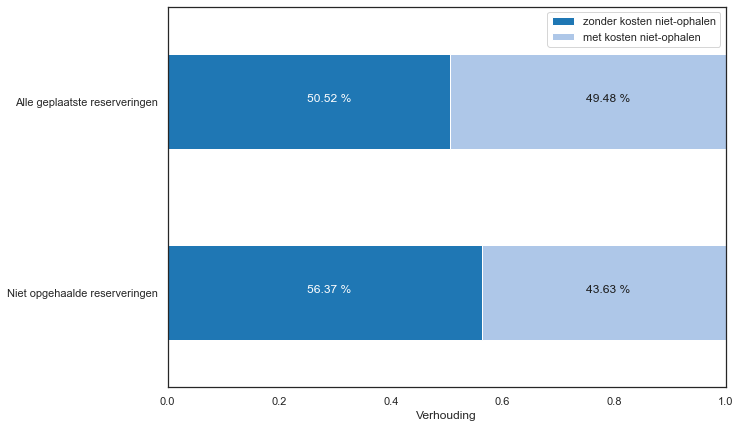

In [33]:
gewoon['met_kosten_niet_ophalen'] = gewoon['kost_niet_ophalen'] > 0

alle_res_met_kosten_niet_ophalen = gewoon.value_counts('met_kosten_niet_ophalen', normalize=True)
niet_opgehaalde_res_met_kosten_niet_ophalen = gewoon[gewoon['archief'] == '8'].value_counts('met_kosten_niet_ophalen', normalize=True)

data = [alle_res_met_kosten_niet_ophalen.values, niet_opgehaalde_res_met_kosten_niet_ophalen.values]


fig, ax = plt.subplots(figsize=FIGSIZE)
height = 0.05
ax.barh(y=0.2, left=0, width=data[0][0], color=TAB20[0], height=height, label='zonder kosten niet-ophalen')
ax.text(x=0.25, y=0.2, s='{:.2f} %'.format(data[0][0] * 100), c='w')
ax.barh(y=0.2, left=data[0][0], width=data[0][1] ,color=TAB20[1], height=height, label='met kosten niet-ophalen')
ax.text(x=0.75, y=0.2, s='{:.2f} %'.format(data[0][1] * 100), c='k')

ax.barh(y=0.1, left=0, width=data[1][0], color=TAB20[0], height=height)
ax.text(x=0.25, y=0.1, s='{:.2f} %'.format(data[1][0] * 100), c='w')
ax.barh(y=0.1, left=data[1][0], width=data[1][1] ,color=TAB20[1], height=height)
ax.text(x=0.75, y=0.1, s='{:.2f} %'.format(data[1][1] * 100), c='k')

ax.set_ylim(0.05, 0.25)
ax.set_xlim(0, 1)
plt.yticks(ticks=(0.2, 0.1), labels=('Alle geplaatste reserveringen', 'Niet opgehaalde reserveringen'))
plt.xlabel('Verhouding')
plt.legend()
plt.show()

# IBL 2022

In [34]:
# dataset voor ibl maken:
ibl = df[df.soort == 'I']

#kolom voor leverende instantie toevoegen:
mapping_levervest = res_params[['vestnr', 'bibliotheek', 'instantie_id']]
mapping_levervest.columns = ['levrvest', 'bibliotheek_leverend', 'instantie_id_leverend']
ibl = ibl.merge(mapping_levervest, how='left', on='levrvest')


print('In totaal waren er {} ibl-reserveringen geplaatst in 2022'.format(ibl.shape[0]))

In totaal waren er 40546 ibl-reserveringen geplaatst in 2022


### IBL per maand en status

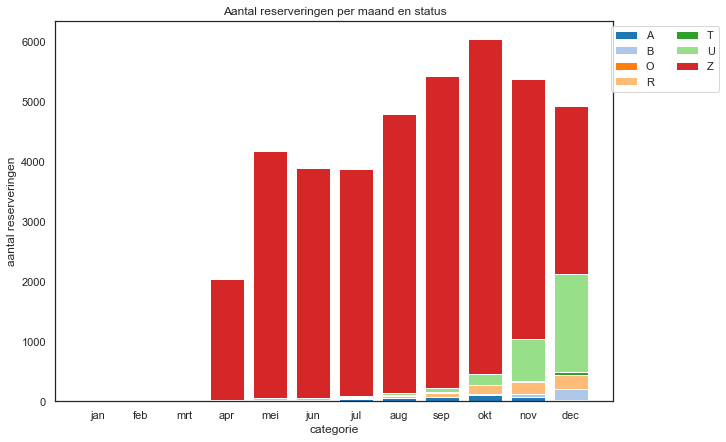

In [35]:
maanden = ['jan', 'feb', 'mrt', 'apr', 'mei', 'jun', 'jul', 'aug', 'sep', 'okt', 'nov', 'dec']

aantal_per_maand_en_status = ibl[['res_dat', 'status']].pivot_table(columns=ibl.res_dat.dt.month, index='status', 
                                                                       aggfunc='count', fill_value=0)
data = aantal_per_maand_en_status.values
statussen = sorted(gewoon['status'].unique())

plot_stacked_bar(data, maanden, statussen, title='Aantal reserveringen per maand en status')

### IBL per maand en archiefreden

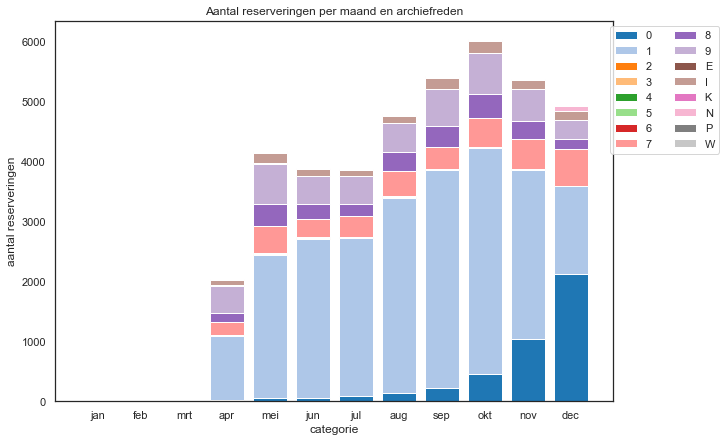

In [36]:
%%capture --no-display

# voor elke archiefreden de aantallen per maand berekenen

# labels en kleuren instellen
archiefredenen = sorted(ibl['archief'].astype(str).unique())

# data berekenen
ibl['archief'] = ibl['archief'].astype(str)  # om geen dubbels owv andere dtype in index te krijgen
aantal_per_maand_en_reden = ibl[['res_dat', 'archief']].pivot_table(columns=ibl.res_dat.dt.month, index='archief', 
                                                                       aggfunc='count', fill_value=0)
data = aantal_per_maand_en_reden.values  # enkel ndarray gebruiken

# data plotten
plot_stacked_bar(data, maanden, archiefredenen, title='Aantal reserveringen per maand en archiefreden')


###  IBL per bron van plaatsing

In vergelijking met gewone reserveringen worden nog altijd meer IBL-aanvragen aan de balie geplaatst dan via internet.

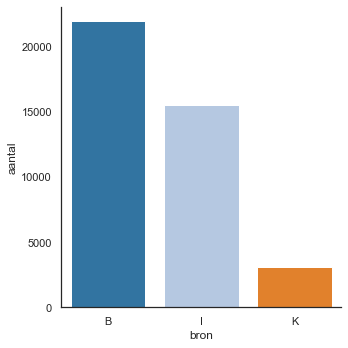

bron  aantal      %
0    B   21942  54.12
1    I   15507  38.25
2    K    3097   7.64

In [37]:
aantal_bron = ibl.groupby('bron').size().reset_index()
aantal_bron.columns = ['bron', 'aantal']

sns.catplot(data=aantal_bron, x='bron', y='aantal', kind='bar', palette=TAB20)
plt.show()

aantal_bron['%'] = round(aantal_bron['aantal'] / len(ibl) * 100, 2)
display(aantal_bron)

### IBL per RMT

Non-fictie wordt vaker via IBL gevraagd dan bij gewone reserveringen. 

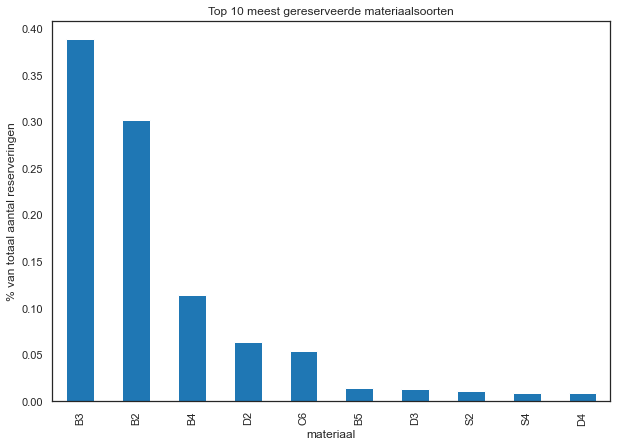

In [38]:
top10_materiaal = ibl.value_counts('materiaal', normalize=True).head(10)

top10_materiaal.plot(kind='bar', figsize=FIGSIZE, color=TAB20[0])
plt.title('Top 10 meest gereserveerde materiaalsoorten')
plt.ylabel('% van totaal aantal reserveringen')
plt.show()

### IBL-aanvragen per bibliotheek

In [39]:
# aantallen per instantie berekenen

# lijst van instantiecodes met verwoording laden
inst_verw = df[['instantie_id', 'bibliotheek']].drop_duplicates()

# berekenen hoeveel reserveringen er per instantie waren
ibl_per_bib = ibl.groupby('instantie_id').size().sort_values(ascending=False).reset_index()
ibl_per_bib.columns = ['instantie_id', 'ibl-reserveringen']

# verwoording van instantiecode aan telling toevoegen
ibl_per_bib = ibl_per_bib.merge(inst_verw, on='instantie_id', how='left')

# bezit per instantie toevoegen
ibl_per_bib = ibl_per_bib.merge(bezit_instantie, on='instantie_id', how='left')

# aantal actieve leners toevoegen
ibl_per_bib = ibl_per_bib.merge(leners, on='instantie_id', how='left')

# parameters voor reserveringen toevoegen
params = res_params[['instantie_id', 'kost_ibl']].drop_duplicates()

# dubbele rij voor Roeselare verwijderen (gratis ibl weg)
roes_mech_gratis = (params['instantie_id'].isin(['I453', 'I739'])) & (params['kost_ibl'] == 0)
params = params.drop(params[roes_mech_gratis].index, axis=0)
ibl_per_bib = ibl_per_bib.merge(params, on='instantie_id', how='left')

count        mean         std  min   25%   50%    75%  \
ibl-reserveringen  301.0  134.704319  198.859403  1.0  43.0  87.0  159.0   

                      max  
ibl-reserveringen  2338.0

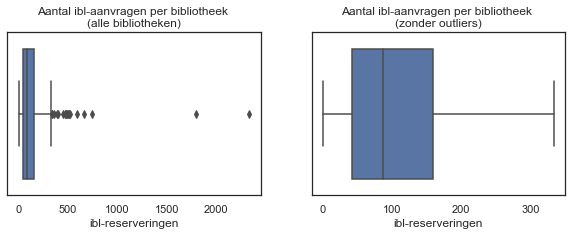


Bibliotheken met meeste ibl-aanvragen: 



Bibliotheken met minst ibl-aanvragen: 


In [40]:
display(ibl_per_bib[['ibl-reserveringen']].describe().T)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.boxplot(data=ibl_per_bib, x='ibl-reserveringen', showfliers=True, ax=axs[0])
sns.boxplot(data=ibl_per_bib, x='ibl-reserveringen', showfliers=False, ax=axs[1])
axs[0].set_title('Aantal ibl-aanvragen per bibliotheek \n(alle bibliotheken)')
axs[1].set_title('Aantal ibl-aanvragen per bibliotheek \n(zonder outliers)')
plt.show()

# top 10 berekenen
top_10_bibliotheken = ibl_per_bib.head(10).set_index('bibliotheek')
bottom_10_bibliotheken = ibl_per_bib.tail(10).sort_values('ibl-reserveringen').set_index('bibliotheek')

top_10_bibliotheken_vet = top_10_bibliotheken.style.applymap(highlight, subset='ibl-reserveringen')
bottom_10_bibliotheken_vet = bottom_10_bibliotheken.style.applymap(highlight, subset='ibl-reserveringen')

print()
print('Bibliotheken met meeste ibl-aanvragen: ')
display(top_10_bibliotheken_vet)

print()
print('Bibliotheken met minst ibl-aanvragen: ')
display(bottom_10_bibliotheken_vet)

In  tegenstelling tot de gewone reserveringen is er bij IBL geen verband tussen de kostprijs voor een IBL en het aantal aanvragen.

Correlatiecoëfficiënt aantal ibl-reserveringen en kostprijs ibl:


ibl-reserveringen  kost_ibl
ibl-reserveringen           1.000000 -0.011969
kost_ibl                   -0.011969  1.000000

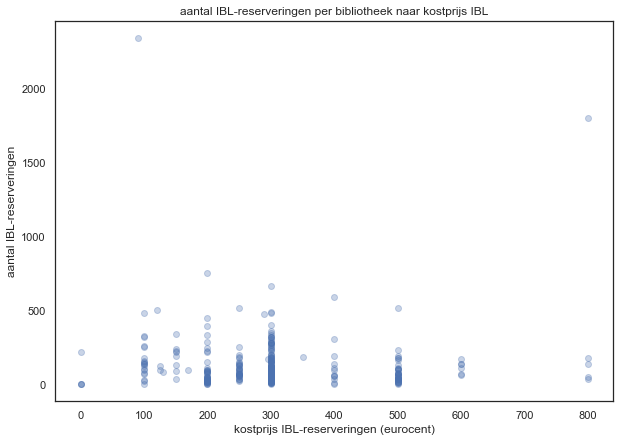

In [41]:
print('Correlatiecoëfficiënt aantal ibl-reserveringen en kostprijs ibl:')
display(ibl_per_bib[['ibl-reserveringen', 'kost_ibl']].corr())

plt.scatter(x=ibl_per_bib['kost_ibl'], 
            y=ibl_per_bib['ibl-reserveringen'],
            alpha=0.3)
plt.title('aantal IBL-reserveringen per bibliotheek naar kostprijs IBL')
plt.ylabel('aantal IBL-reserveringen')
plt.xlabel('kostprijs IBL-reserveringen (eurocent)')
plt.show()


### Geleverde exemplaren voor IBL

In [43]:
# aantallen per instantie berekenen

# berekenen hoeveel reserveringen er per instantie waren
ibl_lever_per_bib = ibl.groupby('instantie_id_leverend').size().sort_values(ascending=False).reset_index()
ibl_lever_per_bib.columns = ['instantie_id_leverend', 'ibl-leveringen']

# verwoording van instantiecode aan telling toevoegen
ibl_lever_per_bib = ibl_lever_per_bib.merge(inst_verw, left_on='instantie_id_leverend', 
                                right_on='instantie_id', how='left')

# bezit per instantie toevoegen
ibl_lever_per_bib = ibl_lever_per_bib.merge(bezit_instantie, left_on='instantie_id_leverend', 
                                            right_on='instantie_id', how='left')

# aantal actieve leners toevoegen
ibl_lever_per_bib = ibl_lever_per_bib.merge(leners, left_on='instantie_id_leverend', 
                                            right_on='instantie_id', how='left')

# parameters voor reserveringen toevoegen
params = res_params[['instantie_id', 'kost_ibl']].drop_duplicates()

# dubbele rij voor Roeselare verwijderen (gratis ibl weg)
roes_mech_gratis = (params['instantie_id'].isin(['I453', 'I739'])) & (params['kost_ibl'] == 0)
params = params.drop(params[roes_mech_gratis].index, axis=0)
ibl_lever_per_bib = ibl_lever_per_bib.merge(params, left_on='instantie_id_leverend', 
                                            right_on='instantie_id', how='left')

# dubbele kolommen na merge verwijderen
ibl_lever_per_bib = ibl_lever_per_bib.drop(['instantie_id_x', 'instantie_id_y'], axis=1)

count        mean         std  min   25%   50%    75%    max
ibl-leveringen  299.0  104.441472  128.807485  1.0  28.0  66.0  125.5  987.0

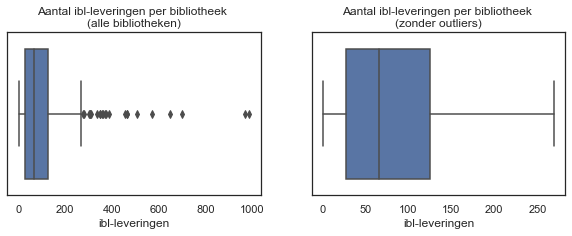


Bibliotheken met meeste ibl-leveringen: 



Bibliotheken met minst ibl-leveringen: 


In [44]:
display(ibl_lever_per_bib[['ibl-leveringen']].describe().T)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.boxplot(data=ibl_lever_per_bib, x='ibl-leveringen', showfliers=True, ax=axs[0])
sns.boxplot(data=ibl_lever_per_bib, x='ibl-leveringen', showfliers=False, ax=axs[1])
axs[0].set_title('Aantal ibl-leveringen per bibliotheek \n(alle bibliotheken)')
axs[1].set_title('Aantal ibl-leveringen per bibliotheek \n(zonder outliers)')
plt.show()

# top 10 berekenen
top_10_bibliotheken = ibl_lever_per_bib.head(10).set_index('bibliotheek')
bottom_10_bibliotheken = ibl_lever_per_bib.tail(10).sort_values('ibl-leveringen').set_index('bibliotheek')

top_10_bibliotheken_vet = top_10_bibliotheken.style.applymap(highlight, subset='ibl-leveringen')
bottom_10_bibliotheken_vet = bottom_10_bibliotheken.style.applymap(highlight, subset='ibl-leveringen')

print()
print('Bibliotheken met meeste ibl-leveringen: ')
display(top_10_bibliotheken_vet)

print()
print('Bibliotheken met minst ibl-leveringen: ')
display(bottom_10_bibliotheken_vet)

# Saldo aanvragen - leveringen per bibliotheek

Aantal aanvragen per bibliotheek min het aantal geleverde ibl-exemplaren

count       mean         std    min  25%   50%   75%     max
saldo  302.0  30.854305  174.195098 -933.0 -1.0  16.0  49.0  2080.0

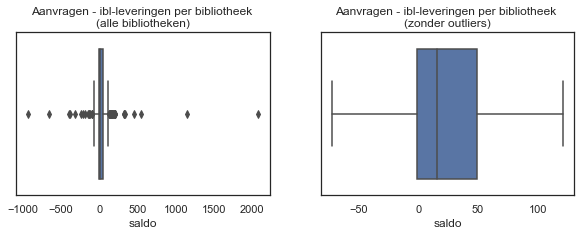


Bibliotheken met meeste aanvragen tov leveringen: 


saldo
bibliotheek                          
Bibliotheek Leuven             2080.0
Bibliotheek Antwerpen          1150.0
Bibliotheek Beveren             551.0
Bibliotheek Puurs-Sint-Amands   461.0
Bibliotheek Merelbeke           338.0
Bibliotheek Kortrijk            326.0
Bibliotheek Mechelen            324.0
Bibliotheek Gavere              209.0
Bibliotheek Sint-Niklaas        207.0
Bibliotheek Geel                204.0


Bibliotheken met meeste leveringen tov aanvragen: 


saldo
bibliotheek                       
Bibliotheek Hasselt Limburg -933.0
Bibliotheek Muntpunt        -654.0
Bibliotheek Zonnebeke       -395.0
Bibliotheek Torhout         -381.0
Bibliotheek Izegem          -311.0
Bibliotheek Roosdaal        -242.0
Bibliotheek Bierbeek        -215.0
Bibliotheek Herentals       -189.0
Bibliotheek Boom            -148.0
Bibliotheek Oostende        -136.0

In [45]:
aanvragen = ibl.groupby('bibliotheek').size()
leveringen = ibl.groupby('bibliotheek_leverend').size()

saldo = aanvragen.sub(leveringen, fill_value=0)

saldo = saldo.sort_values(ascending=False).reset_index()
saldo.columns = ['bibliotheek', 'saldo']

display(saldo.describe().T)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.boxplot(data=saldo, x='saldo', showfliers=True, ax=axs[0])
sns.boxplot(data=saldo, x='saldo', showfliers=False, ax=axs[1])
axs[0].set_title('Aanvragen - ibl-leveringen per bibliotheek \n(alle bibliotheken)')
axs[1].set_title('Aanvragen - ibl-leveringen per bibliotheek \n(zonder outliers)')
plt.show()

# top 10 berekenen
top_10_bibliotheken = saldo.head(10).set_index('bibliotheek')
bottom_10_bibliotheken = saldo.tail(10).sort_values('saldo').set_index('bibliotheek')

print()
print('Bibliotheken met meeste aanvragen tov leveringen: ')
display(top_10_bibliotheken)

print()
print('Bibliotheken met meeste leveringen tov aanvragen: ')
display(bottom_10_bibliotheken)

### IBL-transport

Welke bibliotheken leveren het meest aan wie? 

Leuven ontvangt de meeste IBL-exemplaren, vooral uit grotere bibliotheken. Daarnaast levert Herentals veel exemplaren aan de omliggende Antwerpse bibliotheken.

De 50 grootste aantallen van exemplaren verstuurd tussen 2 bibliotheken:

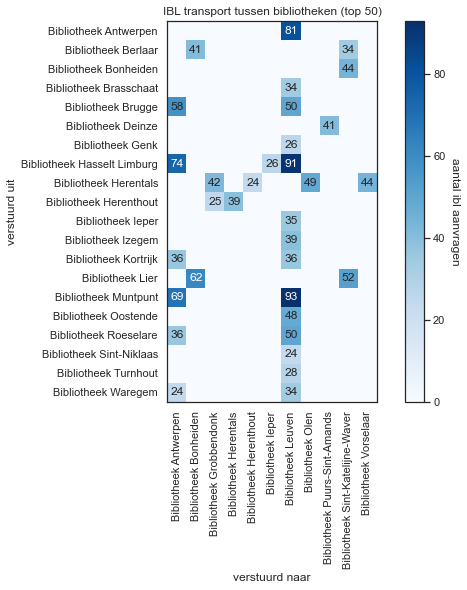

In [46]:
verkeer_ibl = ibl.groupby(['bibliotheek_leverend', 'bibliotheek']).size().sort_values(ascending=False).reset_index().head(50)
verkeer_ibl.columns = ['uit', 'naar', 'aantal']

verkeer_ibl = verkeer_ibl[verkeer_ibl['naar'] != verkeer_ibl['uit']]

verkeer_ibl_tabel = verkeer_ibl.pivot_table(index='uit', columns='naar', values='aantal', fill_value=0)

fig, ax = plt.subplots(figsize=FIGSIZE)
plt.imshow(verkeer_ibl_tabel, cmap='Blues')
for i in range(len(verkeer_ibl_tabel.index)):
    for j in range(len(verkeer_ibl_tabel.columns)):
        text = verkeer_ibl_tabel.values[i][j]
        if text > 60:
            plt.text(j, i, s=text, c='white', horizontalalignment='center', verticalalignment='center')
        elif text > 0:
            plt.text(j, i, s=text, horizontalalignment='center', verticalalignment='center')

cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('aantal ibl aanvragen', rotation=270)
plt.yticks(ticks=range(len(verkeer_ibl_tabel.index)), labels=verkeer_ibl_tabel.index)
plt.xticks(ticks=range(len(verkeer_ibl_tabel.columns)), labels=verkeer_ibl_tabel.columns, rotation=90)
plt.ylabel('verstuurd uit')
plt.xlabel('verstuurd naar')
plt.title('IBL transport tussen bibliotheken (top 50)')
plt.show()


### Hoeveel unieke leners maken gebruik van IBL

Per bibliotheek zijn volgende zaken geteld:

- het aantal unieke leners die minstens 1 IBL-reservering hebben geplaatst
- het gemiddeld aantal IBL-aanvragen per lener met minstens 1 IBL-aanvraag
- het grootst aantal IBL-reserveringen voor 1 lener in de bibliohteek

Bij een hoger aantal IBL-aanvragen per lener kan dat wijzen op intensief gebruik van de dienstverlening door een beperkt aantal leners.

Het gemiddeld aantal IBL-aanvragen per lener ligt op ongeveer 1,88

In [47]:
# aantal unieke leners per bibliotheek die een ibl hebben aangevraagd
unieke_leners_ibl = ibl.groupby('bibliotheek')['actor_id'].nunique()

# max aantal ibl-aanvragen voor 1 lener per bibliotheek
aanvragen_per_lener_per_bib = ibl.groupby(['bibliotheek', 'actor_id']).size().reset_index()
aanvragen_per_lener_per_bib.columns=['bibliotheek', 'actor_id', 'aantal']
max_ibl_per_lener = aanvragen_per_lener_per_bib.groupby('bibliotheek')['aantal'].max()

# aantal ibl-aanvragen per lener berekenen
aantal_ibl_per_lener = ibl_per_bib.set_index('bibliotheek')['ibl-reserveringen'] / unieke_leners_ibl

# alle data over ibl-leners in een dataframe samenvoegen
ibl_leners = ibl_per_bib[['instantie_id', 'bibliotheek', 'ibl-reserveringen', 'kost_ibl']].set_index('bibliotheek')
ibl_leners = ibl_leners.merge(unieke_leners_ibl.rename('unieke_leners_ibl'), 
                              left_index=True, right_index=True, how='left')
ibl_leners = ibl_leners.merge(aantal_ibl_per_lener.rename('ibl_per_lener'),
                             left_index=True, right_index=True, how='left')
ibl_leners = ibl_leners.merge(max_ibl_per_lener.rename('max_ibl_per_lener'), 
                             left_index=True, right_index=True, how='left')

count      mean      std  min       25%       50%       75%  \
ibl_per_lener  301.0  1.877222  0.76559  1.0  1.458333  1.711538  2.060606   

                    max  
ibl_per_lener  8.393443

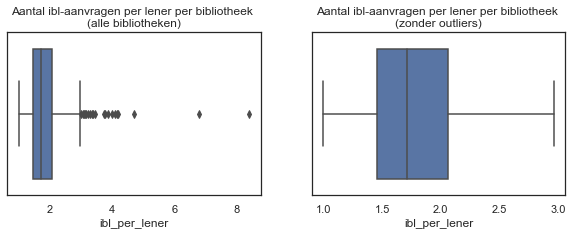


Bibliotheken met meeste ibl-aanvragen per lener: 



Bibliotheken met minst ibl-aanvragen per lener: 


In [48]:
display(ibl_leners[['ibl_per_lener']].describe().T)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3))
sns.boxplot(data=ibl_leners, x='ibl_per_lener', showfliers=True, ax=axs[0])
sns.boxplot(data=ibl_leners, x='ibl_per_lener', showfliers=False, ax=axs[1])
axs[0].set_title('Aantal ibl-aanvragen per lener per bibliotheek \n(alle bibliotheken)')
axs[1].set_title('Aantal ibl-aanvragen per lener per bibliotheek \n(zonder outliers)')
plt.show()

# top 10 berekenen
top_10_bibliotheken = ibl_leners.sort_values('ibl_per_lener', ascending=False).head(10)
bottom_10_bibliotheken = ibl_leners.sort_values('ibl_per_lener', ascending=False).tail(10)

top_10_bibliotheken_vet = top_10_bibliotheken.style.applymap(highlight, subset='ibl_per_lener')
bottom_10_bibliotheken_vet = bottom_10_bibliotheken.style.applymap(highlight, subset='ibl_per_lener')

print()
print('Bibliotheken met meeste ibl-aanvragen per lener: ')
display(top_10_bibliotheken_vet)

print()
print('Bibliotheken met minst ibl-aanvragen per lener: ')
display(bottom_10_bibliotheken_vet)

### Wachttijd geleverde IBL-aanvragen

De helft van de geleverde IBL-aanvragen wordt binnen de 9 dagen na het plaatsen van de aanvraag uitgeleend, drie kwart wordt binnen de twee weken na aanvraag geleend.

count       mean       std  min  25%  50%   75%    max
dagen_wacht  22270.0  11.426493  9.603877  0.0  7.0  9.0  14.0  187.0

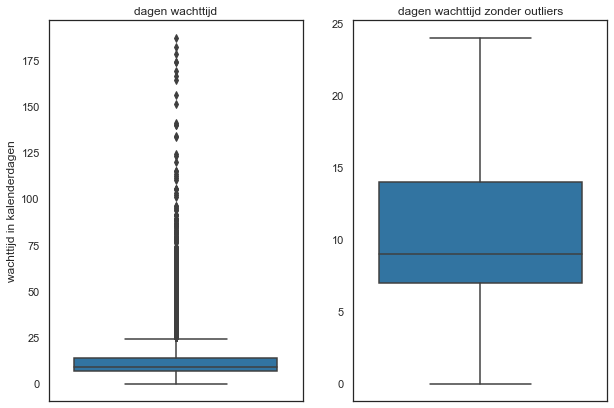

In [49]:
# set maken met alleen gehonoreerde reserveringen
ibl_succes = ibl[(ibl['archief'] == '1') & (ibl['uit_dat'].notnull())]

display(ibl_succes[['dagen_wacht']].describe().T)

fig, ax = plt.subplots(ncols=2, figsize=FIGSIZE)
sns.boxplot(data=ibl_succes, y='dagen_wacht', color=TAB20[0], showfliers=True, ax=ax[0])
sns.boxplot(data=ibl_succes,  y='dagen_wacht', color=TAB20[0], showfliers=False, ax=ax[1])
ax[0].set_title('dagen wachttijd')
ax[0].set_ylabel('wachttijd in kalenderdagen')
ax[1].set_title('dagen wachttijd zonder outliers')
ax[1].set_ylabel('')
plt.show()